In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\jothi\AppData\Local\Temp\tmp6in5t6h3


In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [04:32, 5.91MB/s]                               

2023-11-23 12:35:13,006 - INFO - Downloaded: C:\Users\jothi\AppData\Local\Temp\tmp6in5t6h3\Task09_Spleen.tar


2023-11-23 12:35:15,409 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-11-23 12:35:15,409 - INFO - Writing into directory: C:\Users\jothi\AppData\Local\Temp\tmp6in5t6h3.


In [6]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [7]:
set_determinism(seed=0)

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

c:\Users\jothi\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


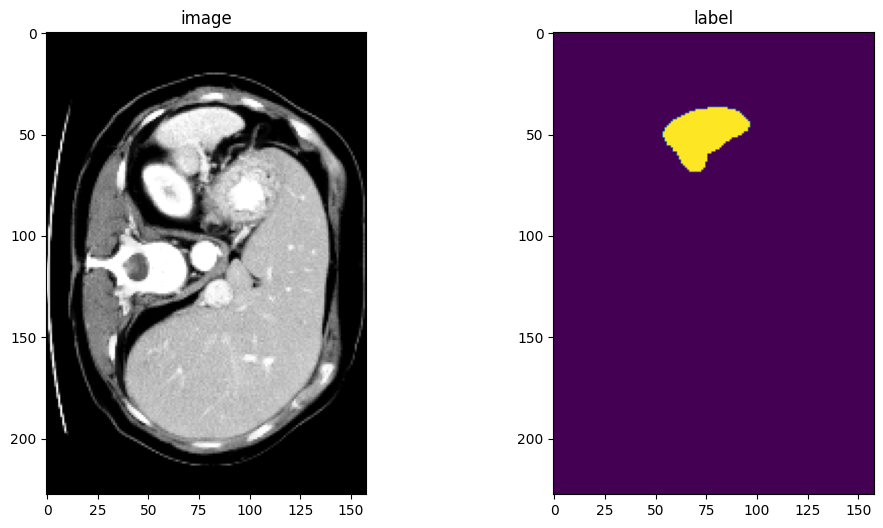

In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [10]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


In [11]:
import monai
from monai.networks.nets import UNet
import torch
import torch.nn as nn
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
from torch.optim import Adam




class INet(nn.Module):
    def __init__(self):
        super(INet, self).__init__()
    # Rest of your code remains the same


        # Use a UNet as the backbone

        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
            )



        # Instance-aware layers
        self.inst_conv1 = nn.Conv3d(2, 64, kernel_size=1)
        self.inst_conv2 = nn.Conv3d(64, 64, kernel_size=1)


        self.out_layer = nn.Conv3d(64, 2, kernel_size=1)

    def forward(self, x):
        x = self.unet(x)

        # Instance embedding
        emb = self.inst_conv1(x)
        emb = self.inst_conv2(emb)

        # Final output
        x = self.out_layer(emb)

        return x

model = INet()

# Rest of the code remains the same
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Train model
for epoch in range(10):
   max_epochs = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"],
            batch_data["label"]
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_dice_coefficients = []  # List to store Dice coefficients for this validation epoch
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"],
                    val_data["label"]
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                val_dice_coefficients.append(dice_metric.aggregate().item())
                # Calculate and display the mean Dice coefficient for this validation epoch
                mean_dice_coefficient = np.mean(val_dice_coefficients)
                print(
                    f"current epoch: {epoch + 1} current mean dice: {mean_dice_coefficient:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
                    )

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "D:/Jodi/Sem7/medical/project/model"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/10
1/16, train_loss: 0.6454
2/16, train_loss: 0.6597
3/16, train_loss: 0.6335
4/16, train_loss: 0.6456
5/16, train_loss: 0.6111
6/16, train_loss: 0.5897
7/16, train_loss: 0.6374
8/16, train_loss: 0.6356
9/16, train_loss: 0.6215
10/16, train_loss: 0.6299
11/16, train_loss: 0.6221
12/16, train_loss: 0.5965
13/16, train_loss: 0.6199
14/16, train_loss: 0.6224
15/16, train_loss: 0.6322
16/16, train_loss: 0.6332
epoch 1 average loss: 0.6272
----------
epoch 2/10
1/16, train_loss: 0.6299
2/16, train_loss: 0.6212
3/16, train_loss: 0.5738
4/16, train_loss: 0.5754
5/16, train_loss: 0.6188
6/16, train_loss: 0.5962
7/16, train_loss: 0.6170
8/16, train_loss: 0.5877
9/16, train_loss: 0.6140
10/16, train_loss: 0.5973
11/16, train_loss: 0.5959
12/16, train_loss: 0.5992
13/16, train_loss: 0.6061
14/16, train_loss: 0.5996
15/16, train_loss: 0.6112
16/16, train_loss: 0.5695
epoch 2 average loss: 0.6008
current epoch: 2 current mean dice: 0.0615
best mean dice: -1.0000 at epoch: -1
curr

In [12]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.3429 at epoch: 10


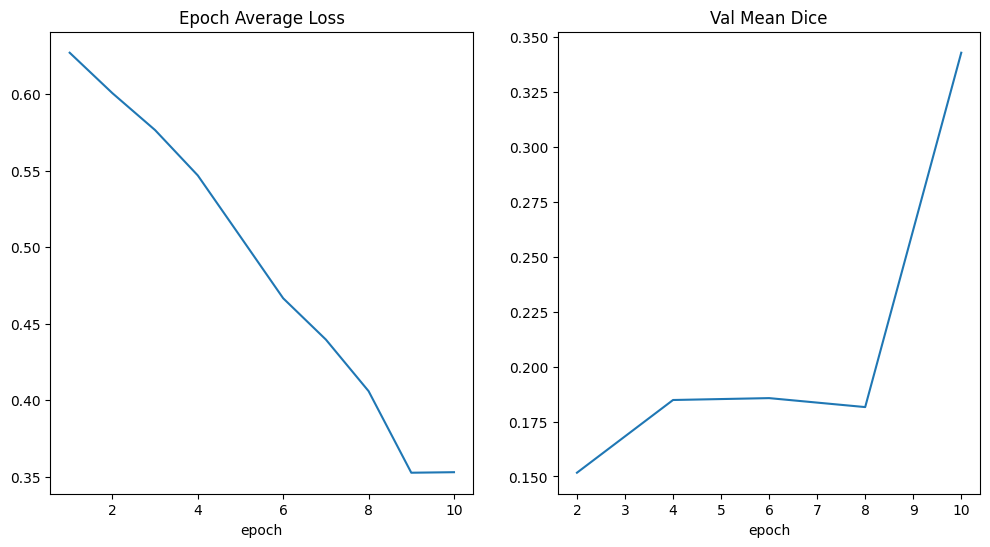

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

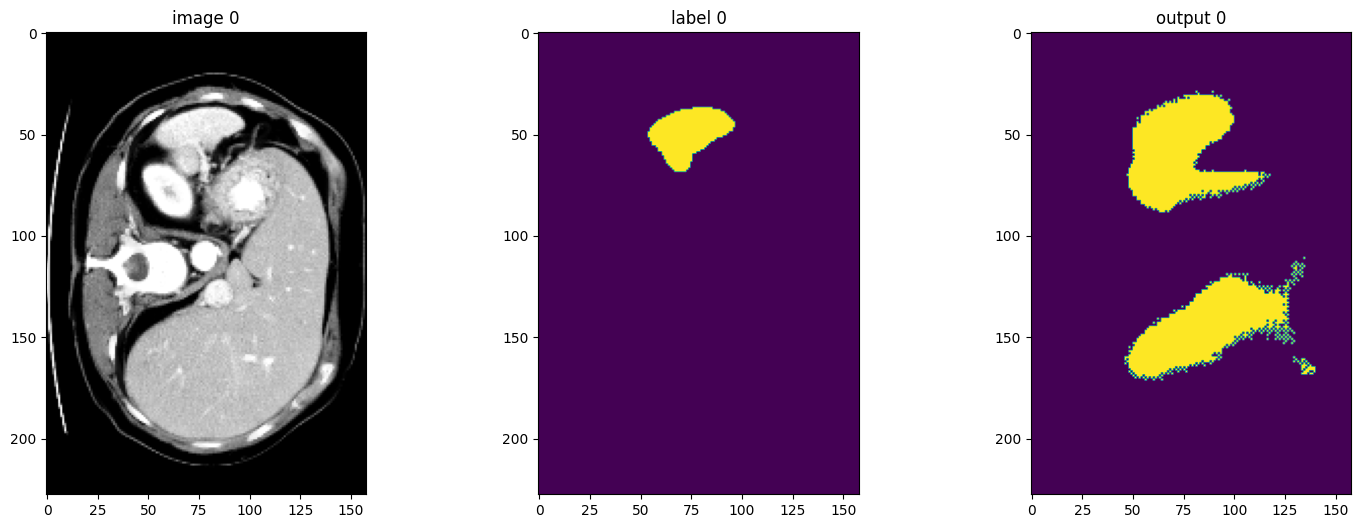

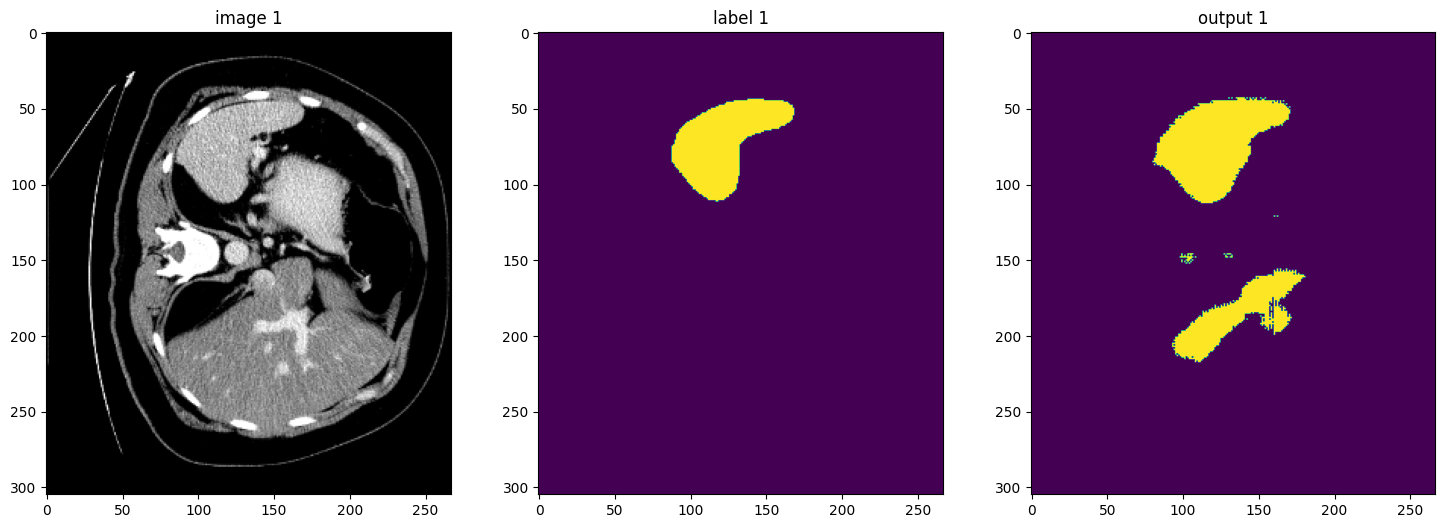

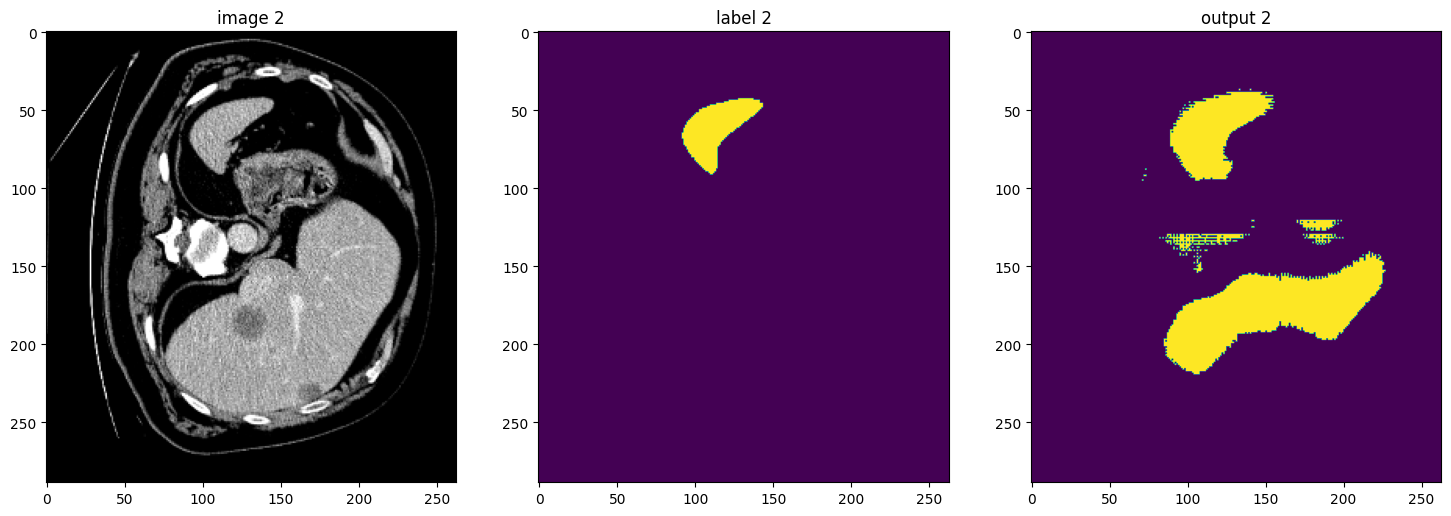

In [14]:
model.load_state_dict(torch.load(os.path.join(root_dir, "D:/Jodi/Sem7/medical/project/model")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"], roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def calculate_dice_coefficient(prediction, ground_truth):
    intersection = np.logical_and(prediction, ground_truth).sum()
    dice = (2.0 * intersection) / (prediction.sum() + ground_truth.sum())
    return dice


In [17]:
# Assuming you have already loaded and set up your model and data

# Set the model in evaluation mode
model.eval()


INet(
  (unet): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        (submodu

In [18]:
dice_scores = []
print(dice_scores)

[]


In [19]:
for val_data in val_loader:
    val_inputs, val_labels = val_data["image"], val_data["label"]

In [20]:
with torch.no_grad():
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]


In [21]:
 # Calculate Dice coefficient for each validation sample
for i in range(len(val_outputs)):
        predicted_seg = val_outputs[i].cpu().numpy()
        ground_truth_seg = val_labels[i].cpu().numpy()
        dice = calculate_dice_coefficient(predicted_seg, ground_truth_seg)
        dice_scores.append(dice)


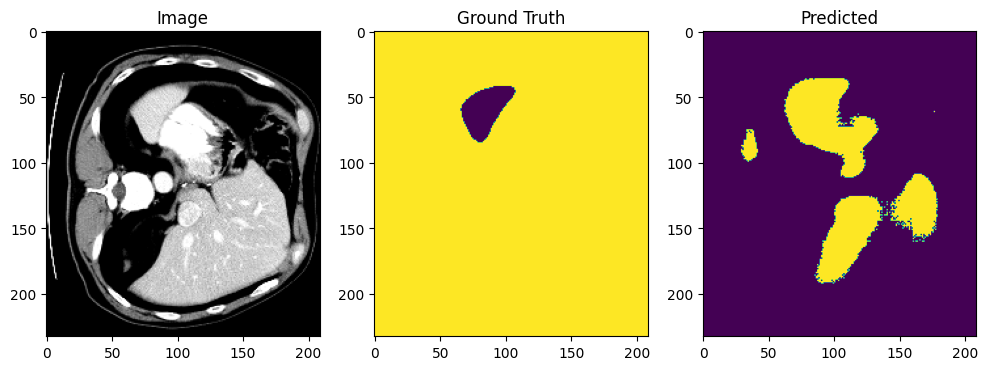

In [22]:
 # Visualize segmentation errors for cases with low Dice coefficients
if dice < 1:
    plt.figure("Segmentation Error", (12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(val_data["image"][i, 0, :, :, 80], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_seg[0, :, :, 80])
    plt.subplot(1, 3, 3)
    plt.title("Predicted")
    plt.imshow(predicted_seg[1, :, :, 80])
    plt.show()


In [23]:
# Calculate the overall Dice coefficient for the dataset
mean_dice = np.mean(dice_scores)
print(f"Mean Dice coefficient: {mean_dice:.4f}")

Mean Dice coefficient: 0.9673
